pip install https://github.com/vBaiCai/python-pesq/archive/master.zip

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pypesq import pesq
import soundfile as sf
from skimage.metrics import structural_similarity as ssim

2022-12-22 08:02:01.611252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 08:02:01.727142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-22 08:02:01.727159: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-22 08:02:02.390390: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
sr=8000
speech_length_pix_sec=27e-3
total_length = 3.6
trim_length = 28400
n_fft=255
frame_length=255
frame_step = 110
arquivo = os.path.join('..','..','bases_vozes','urbansound_8k')
noisefiles = glob.glob(arquivo+os.path.sep+'*.wav')
files = glob.glob('../../bases_vozes/Base_Vozes_IFPB/banco de vozes_mono/vozes_nome/Vozes Mono/**/*.wav')
#files = glob.glob('../../bases_vozes/RAVDESS_8k/**/*.wav')
print(len(files),'sons limpos')
print(len(noisefiles),'sons contaminados')
# print('Should be similar value to trim length', total_length*sr,trim_length)
# print('Should be similar value to n_fft',n_fft, int(speech_length_pix_sec*sr))

91 sons limpos
8732 sons contaminados


In [3]:
@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=sr)
    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = tf.concat([wav, wav, wav], 0)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    return wav

@tf.function
def white_noise(data,factor=0.03):
    noise_amp = factor*tf.reduce_max(data)*tf.random.normal(shape=(1,))
    corr_data = data + noise_amp*tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=0.4,sr=sr):
    noisefile = tf.gather(noisefiles,tf.random.uniform((),0, len(noisefiles)-1,dtype=tf.int32))
    noisefile  = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data)/tf.reduce_max(noisefile) + corr_data 
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

@tf.function
def augment(spectrogram_corr, spectrogram):
    spectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, 10)
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, 20)
    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

@tf.function
def correcao_gamma(spectrogram_corr2, spectrogram2):
    spectrogram_corr2 = tf.image.adjust_gamma(spectrogram_corr2, gamma=0.7, gain=1)
    #print('ooii')
    spectrogram2 = tf.image.adjust_gamma(spectrogram2, gamma=1, gain=1)
    return spectrogram_corr2, spectrogram2

@tf.function
def tf_resize(t, shape):
    """
    Args:
      t: a `Tensor`
      shape: requested output shape
    """
    print(t.shape)
    input_size = tf.size(t)
    output_size = tf.reduce_prod(shape)
    t_flatten = tf.reshape(t, [input_size])
    result = tf.tile(t_flatten, [output_size // input_size + 1])
    print(result[0])
    #result = tf.reshape(result[0:output_size], shape=shape)
    return result, t_flatten, result

In [4]:
choose_audio = files[70]
Audio(f'{choose_audio}', rate=8000)

In [5]:
wav = preprocess_tf(choose_audio)
ruido, data = white_noise(wav)
Audio(ruido, rate=8000)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2022-12-22 08:02:03.128940: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-12-22 08:02:03.335007: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory


2022-12-22 08:02:03.335035: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-22 08:02:03.335057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pedrodsk-vostro): /proc/driver/nvidia/version does not exist
2022-12-22 08:02:03.335352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
mixed = urban_noise(ruido, data)
Audio(mixed, rate=8000)

In [7]:
sinal_voz, fs = librosa.load(choose_audio, sr=8000)
Ts=1/fs

print(f'Frequência: {fs}Hz')
print(f'Amostras: {len(sinal_voz)}')
print(f'Duração do sinal: {len(sinal_voz)/fs}s')

Frequência: 8000Hz
Amostras: 5113
Duração do sinal: 0.639125s


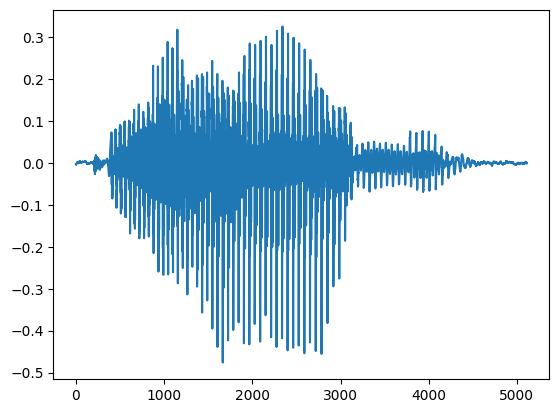

In [8]:
plt.plot(sinal_voz)

In [9]:
sinal_processado = preprocess_tf(choose_audio)

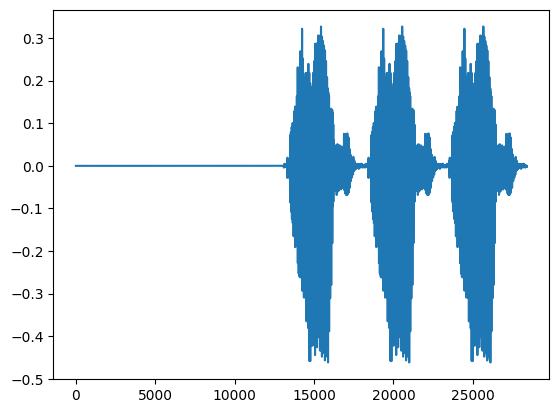

In [10]:
plt.plot(sinal_processado)

In [11]:
print(f'Duração do sinal: {len(sinal_processado)/fs}s')

Duração do sinal: 3.55s


In [12]:
sf.write('teste.wav',sinal_processado,sr)

In [13]:
choose_audio = noisefiles[5000]
Audio(f'{choose_audio}', rate=8000)

In [14]:
sinal, fs = librosa.load(choose_audio, sr=8000)
Ts=1/fs

print(f'Frequência: {fs}Hz')
print(f'Amostras: {len(sinal)}')
print(f'Duração do sinal: {len(sinal)/fs}s')

Frequência: 8000Hz
Amostras: 28400
Duração do sinal: 3.55s


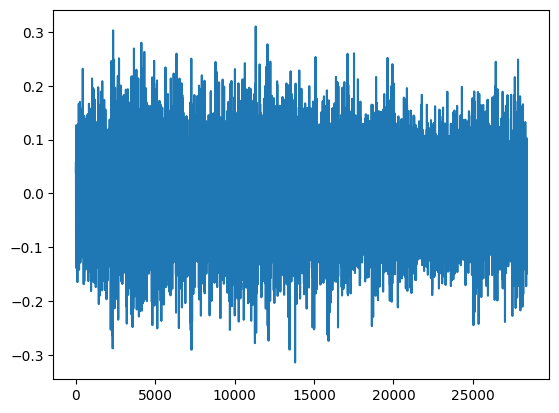

In [15]:
plt.plot(sinal)

In [16]:
sinal_processado.shape

TensorShape([28400])

# Criação do dataset

In [17]:
if len(files) == 1440:
    train_val_split_ratio = 0.2
else:
    train_val_split_ratio = 0.99

batch_size=16
split_index = int(len(files)*train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]

print(f'Quantidade de imagens de treino {len(train_files)}')
print(f'Quantidade de imagens de validação {len(val_files)}')

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    
    if not train:
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)
        #dataset = dataset.map(correcao_gamma, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(correcao_gamma, num_parallel_calls=tf.data.AUTOTUNE)
        
        dataset = dataset.batch(batch_size)
        dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

Quantidade de imagens de treino 1
Quantidade de imagens de validação 90


In [18]:
train_dataset = configure_dataset(train_files)
val_dataset = configure_dataset(val_files)

In [19]:
train_ds = train_dataset.unbatch()
images = list(train_ds.map(lambda x, y: x))
labels = list(train_ds.map(lambda x, y: y))

print(len(labels))
print(len(images))

1
1


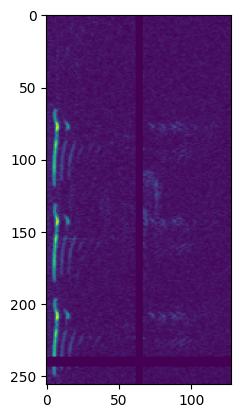

In [20]:
plt.imshow(images[0])

In [21]:
new_image = tf.image.adjust_gamma(
    images[0], gamma=0.5, gain=1
)

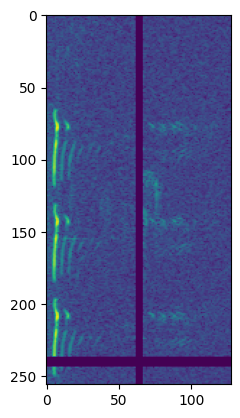

In [22]:
plt.imshow(new_image)

In [23]:
len(train_files)

1

In [24]:
len(val_files)

90

# Arquitetura da rede

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
)


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    """Attention gate. Compresses both inputs to n_intermediate_filters filters before processing.
       Implemented as proposed by Oktay et al. in their Attention U-net, see: https://arxiv.org/abs/1804.03999.
    """
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    """Performs concatenation of upsampled conv_below with attention gated version of skip-connection
    """
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",  # 'deconv' or 'simple'
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=16,
    num_layers=4,
    output_activation="sigmoid",
):  # 'sigmoid' or 'softmax'

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    inputs_copy = tf.identity(inputs)
    x = inputs / tf.reduce_max(inputs)

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2  # double the number of filters with each layer

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2  # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)
    outputs = keras.layers.Multiply()([output_mask, inputs_copy])
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## Transfer Learning

In [26]:
model = custom_unet(
    input_shape=(256, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=16, 
    num_layers=4,
    dropout=0.2,
    output_activation='sigmoid')

model_filename = 'model_preprocess3_weights.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True)

callback_early_stop =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

def signal_enhancement_loss(y_true, y_pred):
    mae = tf.abs(y_true - y_pred)
    speech_loss =  2 * tf.abs(y_true**2 - y_pred*y_true)
    return tf.reduce_mean(mae, axis=-1) + tf.reduce_mean(speech_loss, axis=-1)

model.compile(optimizer='adam', loss=signal_enhancement_loss)

## Carregar modelo

In [27]:
model.load_weights('modelos/speech_mask_model/model_preprocess2_weights.h5')

## Treinamento da rede

# PESQ

In [28]:
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test,train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()

In [29]:
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array =  np.zeros((len(files_to_test),trim_length))
wav_corrupt_array =  np.zeros((len(files_to_test),trim_length))
wav_correct_array =  np.zeros((len(files_to_test),trim_length))
spec_clean_array=  np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array=  np.zeros((len(files_to_test), 256, 128))
spec_correct_array=  np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))


for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    #corr_amp = tf.image.adjust_gamma(corr_amp, gamma=0.7, gain=1)
    corrected_amp = model.predict(np.expand_dims(corr_amp,0))
    corrected_spec = corrected_amp * np.exp(1j*np.angle(np.expand_dims(corr,0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step) 
     
    pesq_with_noise[ind] = pesq(clean_wav,corr_wav,sr)
    pesq_denoised[ind] = pesq(clean_wav,corrected_wav,sr)
    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:,:,0])
    spec_corrupt_array[ind] = np.abs(corr[:,:,0])
    spec_correct_array[ind] = corrected_amp[0,:,:,0]
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] =tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:,:,0]), corrected_amp[0,:,:,0])).numpy()

pesq_diff = pesq_denoised - pesq_with_noise

print(np.mean(pesq_with_noise), np.mean(pesq_denoised),pesq_diff.mean())

f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'

1/1 [==============================] - 0s 41ms/step
2.077450669474072 2.4361076209280226 0.35865695145395066


'2.08, 2.44'

In [30]:
!rm -r val_results

In [31]:
results_dir = 'val_results'
os.mkdir(results_dir)

Text(0, 0.5, 'Number')

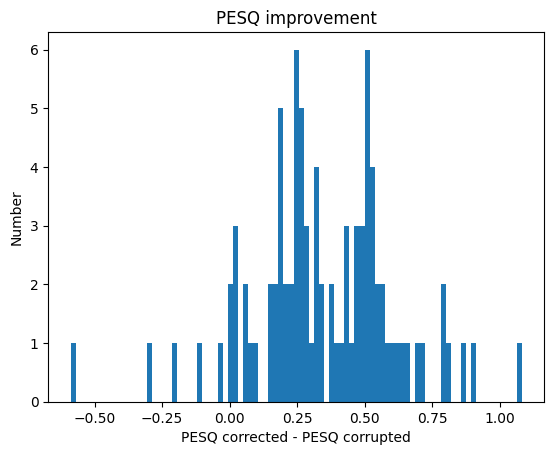

In [46]:
fig = plt.figure()
plt.title('PESQ improvement')
plt.hist(pesq_diff, bins=len(pesq_diff));
plt.xlabel('PESQ corrected - PESQ corrupted')
plt.ylabel('Number')

In [33]:
len(pesq_diff)

90

In [34]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
sf.write(results_dir +'/'+'clean_best_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_best_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_best_pesq_improvement.wav',wav_correct_array[ind],sr)

In [35]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
ind

41

In [36]:
pesq_diff = np.delete(pesq_diff, ind)

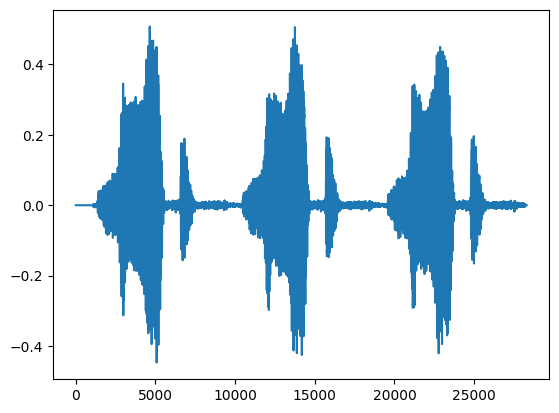

In [37]:
plt.plot(wav_clean_array[ind])
Audio(wav_clean_array[ind],rate=sr)

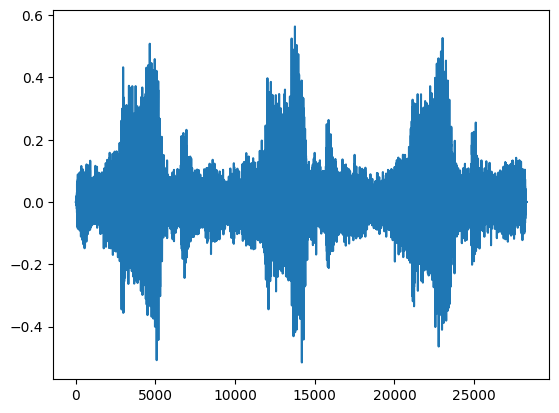

In [38]:
plt.plot(wav_corrupt_array[ind])
Audio(wav_corrupt_array[ind],rate=sr)

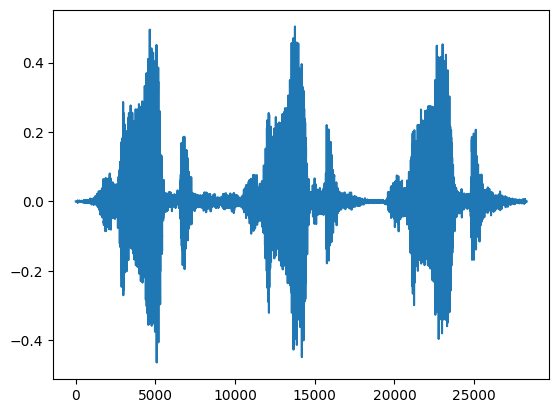

In [39]:
plt.plot(wav_correct_array[ind])
Audio(wav_correct_array[ind],rate=sr)

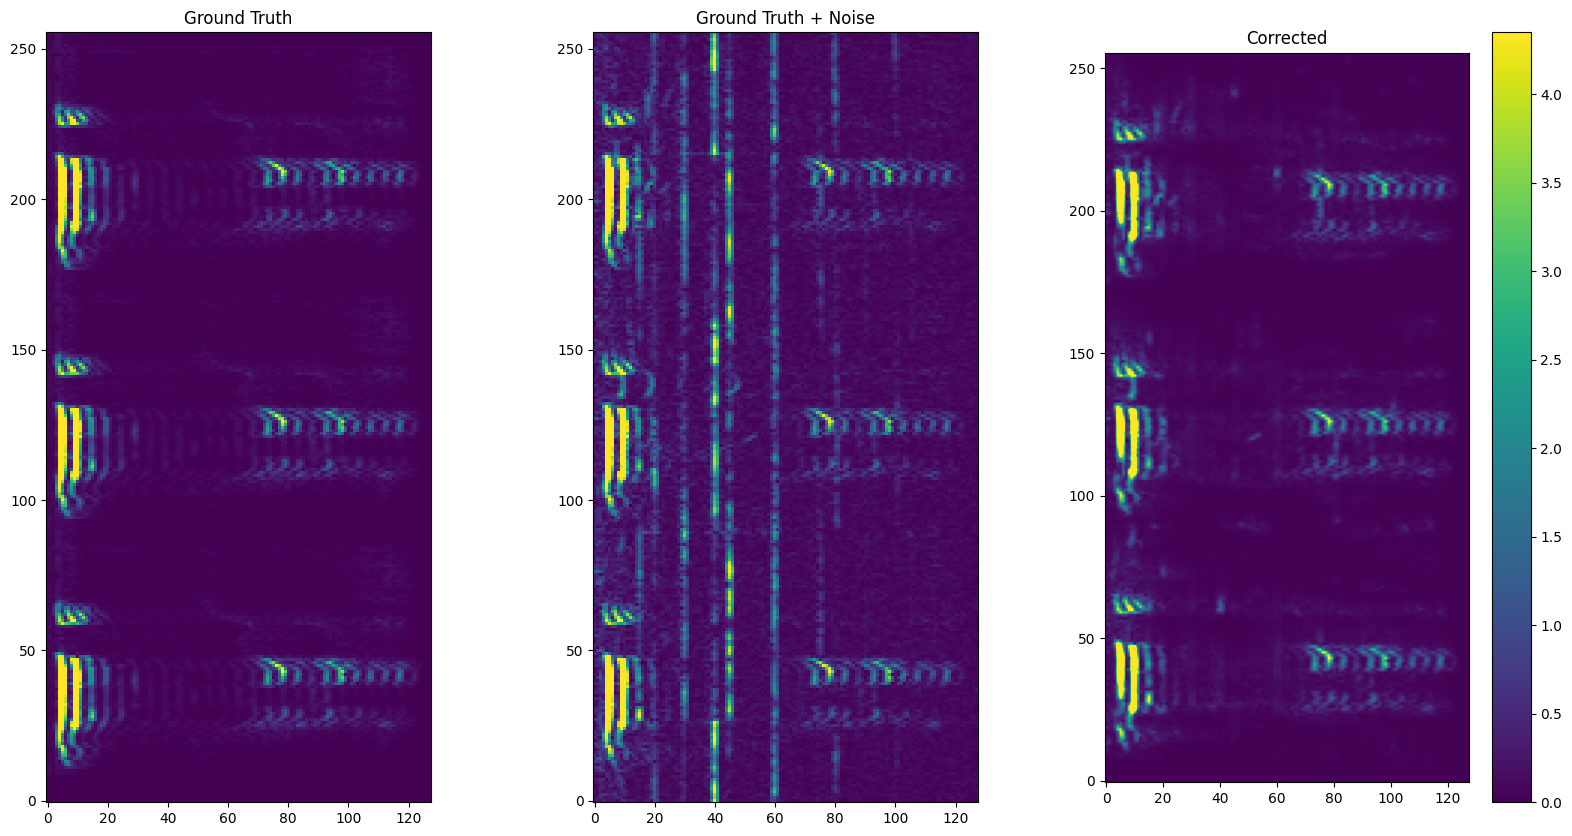

In [40]:
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()

In [41]:
test_ = np.expand_dims(corr_amp,0)

In [42]:
%%timeit -n 50
test = model.predict(test_)

1/1 [==============================] - 0s 44ms/step
75 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [43]:
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')

val_results/
val_results/corrupt_best_pesq_improvement.wav
val_results/correct_best_pesq_improvement.wav
val_results/clean_best_pesq_improvement.wav


0

In [44]:
!rm train_val_results.tar.gz

In [45]:
RAVDESS_8k

1440 sons limpos
8732 sons contaminados

Quantidade de imagens de treino 1152 (80%)
Quantidade de imagens de validação 288 (20%)


modelo retreinado '2.10, 2.52'
modelo com preprocessamento1 '2.09, 2.65'
modelo com preprocessamento2 '2.05, 2.65'
modelo com preprocessamento3 '2.06, 2.68'


VOZES_IFPB

91 sons limpos
8732 sons contaminados

Quantidade de imagens de treino 1
Quantidade de imagens de validação 90 (99%)


modelo retreinado '1.98, 2.24'
modelo preprocessamento1 '2.01, 2.30'
modelo preprocessamento2 '1.99, 2.43'
modelo com preprocessamento3 '2.02, 2.39'

SyntaxError: invalid syntax (2839079588.py, line 3)

# SSIM

In [ ]:
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test,train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()

In [ ]:
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array =  np.zeros((len(files_to_test),trim_length))
wav_corrupt_array =  np.zeros((len(files_to_test),trim_length))
wav_correct_array =  np.zeros((len(files_to_test),trim_length))
spec_clean_array=  np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array=  np.zeros((len(files_to_test), 256, 128))
spec_correct_array=  np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))
ssim_clean_correct = []
ssim_clean_corrupt = []


for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp,0))
    corrected_spec = corrected_amp * np.exp(1j*np.angle(np.expand_dims(corr,0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step) 
           
    #pesq_with_noise[ind] = pesq(clean_wav,corr_wav,sr)
    #pesq_denoised[ind] = pesq(clean_wav,corrected_wav,sr)
    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:,:,0])
    spec_corrupt_array[ind] = np.abs(corr[:,:,0])
    spec_correct_array[ind] = corrected_amp[0,:,:,0]
    ssim_clean_correct.append(ssim(spec_clean_array[ind],spec_correct_array[ind]))
    ssim_clean_corrupt.append(ssim(spec_clean_array[ind],spec_corrupt_array[ind]))
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] =tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:,:,0]), corrected_amp[0,:,:,0])).numpy()

In [ ]:
print(f'Média do SSIM para espectrogramas corrigidos: {round(np.mean(ssim_clean_correct),4)}')
print(f'Média do SSIM para espectrogramas contaminados: {round(np.mean(ssim_clean_corrupt),4)}')

ssim_clean_correct

pior_ind_correct, pior_val_correct

len(ssim_clean_correct)

In [ ]:
def maximo(lista):
    
    maior_valor = None
    maior_ind = None
    
    for ind, num in list(enumerate(lista)):
        if(maior_valor is None or num > maior_valor):
            maior_valor = num
            maior_ind = ind
    
    return maior_ind, maior_valor

In [ ]:
def minimo(lista):
    
    menor_valor = None
    menor_ind = None
    
    for ind, num in list(enumerate(lista)):
        if(menor_valor is None or num < menor_valor):
            menor_valor = num
            menor_ind = ind
    
    return menor_ind, menor_valor

In [ ]:
melhor_ind_correct, melhor_val_correct = maximo(ssim_clean_correct)
melhor_ind_correct, melhor_val_correct

In [ ]:
pior_ind_correct, pior_val_correct = minimo(ssim_clean_correct)
pior_ind_correct, pior_val_correct

In [ ]:
melhor_ind_corrupt, melhor_val_corrupt = maximo(ssim_clean_corrupt)
melhor_ind_corrupt, melhor_val_corrupt

In [ ]:
pior_ind_corrupt, pior_val_corrupt = minimo(ssim_clean_corrupt)
pior_ind_corrupt, pior_val_corrupt

# Melhor Índice 

In [ ]:
ind = melhor_ind_correct
fig,axes = plt.subplots(ncols=3,figsize=(10,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
melhor_ind_correct, melhor_val_correct

In [ ]:
Audio(wav_clean_array[ind], rate=sr)

In [ ]:
Audio(wav_corrupt_array[ind], rate=sr)

In [ ]:
Audio(wav_correct_array[ind], rate=sr)

# Pior Índice

In [ ]:
ind = pior_ind_correct
fig,axes = plt.subplots(ncols=3,figsize=(10,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
pior_ind_correct, pior_val_correct

In [ ]:
Audio(wav_clean_array[ind], rate=sr)

In [ ]:
Audio(wav_corrupt_array[ind], rate=sr)

In [ ]:
Audio(wav_correct_array[ind], rate=sr)